In [1]:
import gymnasium
import numpy as np
import scipy.linalg
import casadi as cs
from ml_collections import config_dict
import matplotlib.pyplot as plt
from IPython.display import clear_output 
import jax
jax.config.update("jax_enable_x64", True)

from crazyflow.control import Control
from crazyflow.sim.physics import Physics

from crazyflow.sim.symbolic import symbolic
from crazyflow.constants import MASS, GRAVITY, J

In [2]:
sim_config = config_dict.ConfigDict()
sim_config.device = "cpu"
sim_config.physics = Physics.default
sim_config.control = Control.thrust
sim_config.thrust_freq = 500
sim_config.n_drones = 1
sim_config.n_worlds = 1 #20

envs = gymnasium.make_vec(
    "DroneReachPos-v0",
    # return_datatype="numpy",
    num_envs=sim_config.n_worlds,
    **sim_config,
)

In [3]:
from scipy.spatial.transform import Rotation as R

def obs_to_state(obs):
    # Extract position
    pos = obs["pos"].squeeze()  # shape: (3,)
    
    # Extract linear velocity
    vel = obs["vel"].squeeze()  # shape: (3,)
    
    # Extract orientation as quaternion and convert to Euler angles
    quat = obs["quat"].squeeze()  # shape: (4,)
    euler = R.from_quat(quat).as_euler("xyz")  # shape: (3,), Euler angles
    # euler = euler[::-1] # [roll, pitch, yaw]
    # Extract angular velocity
    rpy_rates = obs["rpy_rates"].squeeze()  # shape: (3,)
    
    # Concatenate into a single state vector
    state = np.array([pos[0],vel[0],pos[1],vel[1],pos[2],vel[2],*euler, *rpy_rates])
    
    return state

创建symbolic

In [4]:
dt = 1/envs.sim.freq
symbolic_model = symbolic(MASS, J, dt)

In [5]:
y_sim_log = []
z_sim_log = []
x_sim_log = []
x_sym_log = []
y_sym_log = []
z_sym_log = []

In [6]:
obs, info = envs.reset()
state = obs_to_state(obs)
print(state)
x_sim_log.append(state[0])
y_sim_log.append(state[2])
z_sim_log.append(state[4])

x_sym_log.append(state[0])
y_sym_log.append(state[2])
z_sym_log.append(state[4])

[-0.63619956 -0.62184283  0.37771344 -0.5953036   1.70957813  0.34862099
  0.          0.          0.          0.          0.          0.        ]


/Users/luyi/Downloads/TUM/HiWi_dev/crazyflow/.venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


随机生成acttion

In [7]:
low = 0.028161688
high = 0.14834145
shape = (1, 4)
xf = state

for i in range(200):
    random_input = np.random.uniform(low=low, high=high, size=shape).astype(np.float32)

    print("input:", random_input)

    res = symbolic_model.fd_func(x0=xf, p=random_input)
    xf = res["xf"].full().flatten()
    print("xf from symbolic:", xf)
    x_sym_log.append(xf[0])
    y_sym_log.append(xf[2])
    z_sym_log.append(xf[4])

    obs, reward, terminated, truncated, info = envs.step(random_input)
    state = obs_to_state(obs)

    print("state from sim:", state)
    x_sim_log.append(state[0])
    y_sim_log.append(state[2])
    z_sim_log.append(state[4])
envs.close()

input: [[0.11350592 0.08089504 0.08181137 0.09881559]]
xf from symbolic: [-6.37443253e-01 -6.21855847e-01  3.76522839e-01 -5.95299982e-01
  1.71028353e+00  3.56780834e-01 -3.74107241e-04 -1.34761692e-03
 -2.39715435e-05 -3.74126533e-01 -1.34760434e+00 -2.42459659e-02]
state from sim: [-0.63744325 -0.62184283  0.37652284 -0.5953036   1.71027537  0.35678084
  0.          0.          0.         -0.37411874 -1.34760625 -0.02424593]
input: [[0.0760636  0.09616101 0.13324963 0.14292327]]
xf from symbolic: [-6.38687039e-01 -6.21942182e-01  3.75332244e-01 -5.95306906e-01
  1.71101068e+00  3.70375335e-01  1.70103846e-03 -3.75971191e-03
 -2.66071905e-05  2.44923320e+00 -1.06447492e+00  2.20052851e-02]
state from sim: [-6.38686932e-01 -6.21842827e-01  3.75332230e-01 -5.95303597e-01
  1.71098893e+00  3.70375467e-01 -7.48237474e-04 -2.69521250e-03
 -4.84918673e-05  2.44909792e+00 -1.06457942e+00  2.94028472e-02]
input: [[0.10815965 0.11276399 0.11464374 0.13808534]]
xf from symbolic: [-6.39931083e-

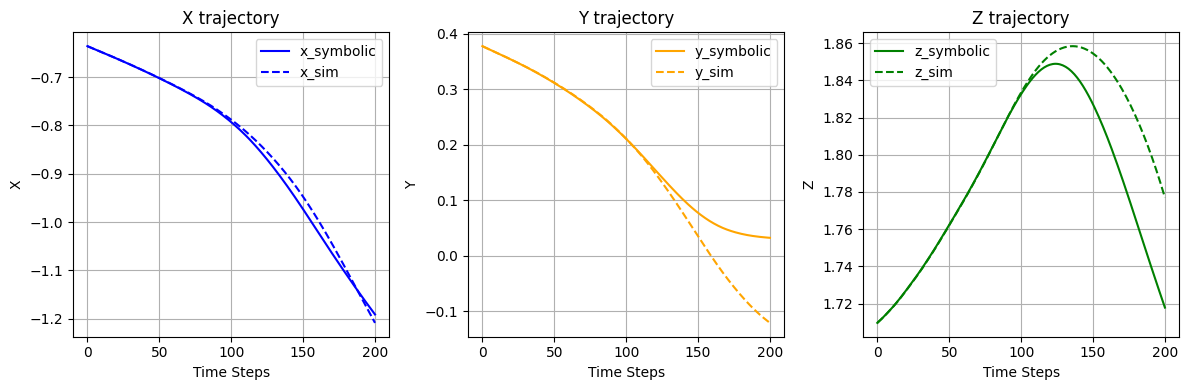

In [8]:
time = np.arange(len(x_sym_log))  

plt.figure(figsize=(12, 4))

# X
plt.subplot(1, 3, 1)
plt.plot(time, x_sym_log, label='x_symbolic', color='blue')
plt.plot(time, x_sim_log, label='x_sim', color='blue', linestyle='--')
plt.title('X trajectory')
plt.xlabel('Time Steps')
plt.ylabel('X')
plt.legend()
plt.grid(True)

# Y
plt.subplot(1, 3, 2)
plt.plot(time, y_sym_log, label='y_symbolic', color='orange')
plt.plot(time, y_sim_log, label='y_sim', color='orange', linestyle='--')
plt.title('Y trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Y')
plt.legend()
plt.grid(True)

# Z
plt.subplot(1, 3, 3)
plt.plot(time, z_sym_log, label='z_symbolic', color='green')
plt.plot(time, z_sim_log, label='z_sim', color='green', linestyle='--')
plt.title('Z trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Z')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()